# Explore extracted BETA-Features based on SSD

### 0) Load packages and functions

In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np

import sklearn as sk
from scipy import signal, stats

import matplotlib.pyplot as plt



In [2]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [3]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')
feat_path = os.path.join(projectpath, 'results', 'features')

In [4]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_plotting.expl_plotting as expl_plot



import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults
import lfpecog_analysis.get_acc_derivs as accDerivs


from lfpecog_plotting.plotHelpers import remove_duplicate_legend

### 1) Define settings

In [6]:
SETTINGS = utilsFiles.load_ft_ext_cfg(cfg_fname='ftExtr_spectral_v1.json')

ssd_ft_path = os.path.join(feat_path, 'SSD_feats',
                           SETTINGS['DATA_VERSION'],
                           f"windows_{SETTINGS['WIN_LEN_sec']}s_"
                           f"{SETTINGS['WIN_OVERLAP_part']}overlap")
IGNORE_PTS = ['010', '011']  # 011 did not start in OFF, 010: check ECoG

SUBS_STUN_EFFECT = ['009', '014', '016']

In [7]:
# get all available subs with features 
SUBS = list(set([name.split('_')[1] for name in os.listdir(ssd_ft_path)]))

for sub in IGNORE_PTS:
    if sub in SUBS: SUBS.remove(sub)

### 1a) Load Clinical Scores

OFF definition:
    
    - up to 15 minutes after L-Dopa intake (max. dopa_time is 15)
    
    - no CDRS in total (max. CDRS total is 0)

    
ON definition:
    
    - at least 45 minutes after L-Dopa intake (min. dopa time is 45)
    
    - no severe Dyskinesia (max CDRS total is 5)


Stun-effect: sub-analysis on patients with significant OFF-reduction after OR versus pre-operative

In [42]:
ft_times = fts.sub008.powers.index.values
scores_values = fts.sub008.scores.total
scores_minutes = fts.sub008.scores.times
ft_minutes = ft_times / 60

scores_minutes

array([0, 3.999999999999986, 7.999999999999972, 11.999999999999957,
       19.950000000000003, 20.56666666666663, 22.433333333333294, 23,
       26.43333333333328, 32.28333333333332], dtype=object)

In [47]:
sub_times

array([0.01666667, 0.01944444, 0.02222222, 0.025     , 0.02777778,
       0.03055556, 0.03333333, 0.03611111, 0.03888889, 0.04166667,
       0.04444444, 0.04722222, 0.05      , 0.05277778, 0.05555556,
       0.05833333, 0.06111111, 0.06388889, 0.06666667, 0.06944444,
       0.07222222, 0.075     , 0.07777778, 0.08055556, 0.08333333,
       0.08611111, 0.08888889, 0.09166667, 0.09444444, 0.09722222,
       0.1       , 0.10277778, 0.10555556, 0.10833333, 0.11111111,
       0.11388889, 0.11666667, 0.11944444, 0.12222222, 0.125     ,
       0.12777778, 0.13055556, 0.13333333, 0.15555556, 0.15833333,
       0.16111111, 0.16388889, 0.16666667, 0.16944444, 0.17222222,
       0.175     , 0.17777778, 0.18055556, 0.18333333, 0.18611111,
       0.18888889, 0.19166667, 0.19444444, 0.19722222, 0.2       ,
       0.20277778, 0.20555556, 0.20833333, 0.21111111, 0.21388889,
       0.21666667, 0.21944444, 0.22222222, 0.225     , 0.22777778,
       0.23055556, 0.23333333, 0.23611111, 0.23888889, 0.24166

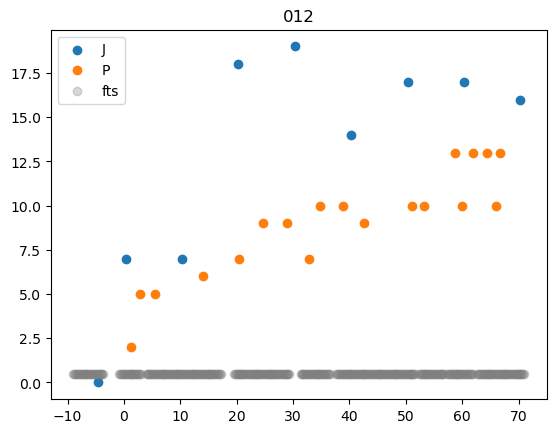

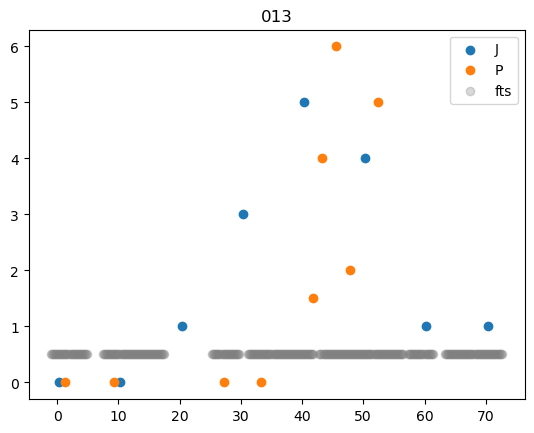

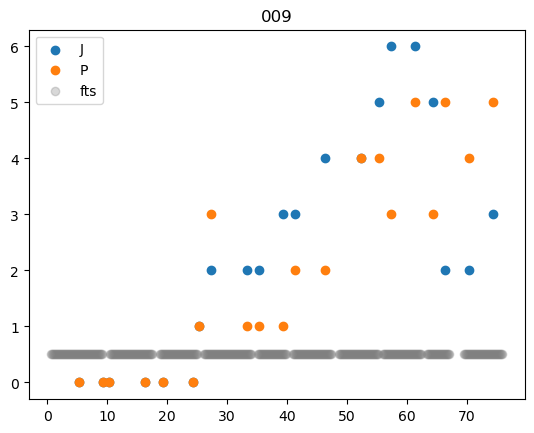

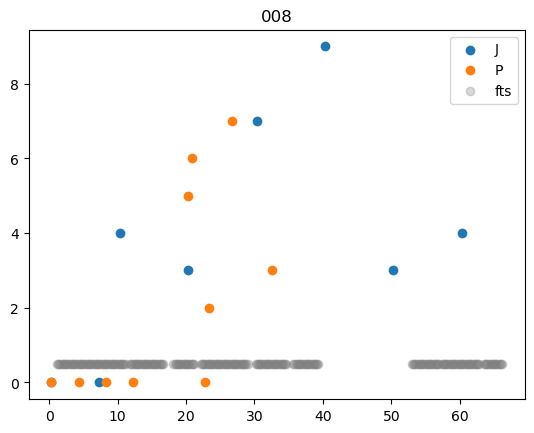

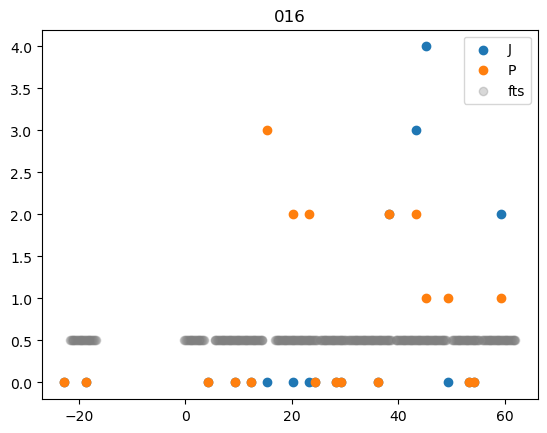

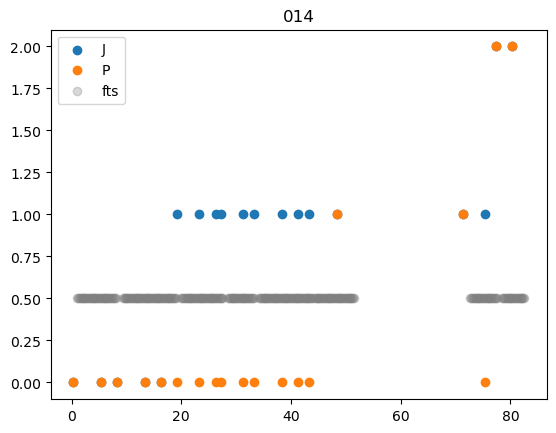

In [51]:


for sub in SUBS:
        
    cdrss = {}
    for rater in ['Patricia', 'Jeroen']:
        cdrss[rater[0]] = importClin.read_clinical_scores(sub=sub, rater=rater)

    sub_times = getattr(fts, f'sub{sub}').powers.index.values.copy()
    sub_times /= 60

    # off_times_sel = 

    for rater in ['J', 'P']:
        plt.scatter(cdrss[rater]['dopa_time'] + .3,
                    cdrss[rater]['CDRS_total'],
                    label=rater)

    plt.scatter(sub_times, [.5] * len(sub_times),
                color='gray', alpha=.3, label='fts')
    plt.title(sub)
    plt.legend()
    plt.show()

In [25]:
SCORES = {}
ECOG_SIDES = {}
REMOVE_TIMES = {}  # remove moments with only 'WRONG SIDE' dyskinesia

for sub in SUBS:
        # # GET UNILATERAL (CONTRA ECOG) CDRS SCORES
        # scores_temp = importClin.read_clinical_scores(sub=sub,
        #                                               rater='Patricia')
        #         # check if scores are present
        # if type(scores_temp) == type(None):
        #         print(f'None CDRS-scores loaded for sub {sub}')
        #         continue

        # # get ECoG-side
        # ecog_side = importClin.get_ecog_side(sub)
        # ECOG_SIDES[sub] = ecog_side
        # # define CDRS of body-side to include
        # if ecog_side == 'left': LID_side_incl = 'right'
        # elif ecog_side == 'right': LID_side_incl = 'left'
        
        # # identify minutes to remove bcs only Dyskinesia at none-ECoG side
        # REMOVE_TIMES[sub] = []
        # for i, t in enumerate(scores_temp['dopa_time']):
        #         if np.logical_and(scores_temp.iloc[i][f'CDRS_total_{LID_side_incl}'] < 1,
        #                           scores_temp.iloc[i][f'CDRS_total_{ecog_side}'] > 0):
        #                 REMOVE_TIMES[sub].append(t)

        # # include selected CDRS
        # SCORES[sub] = scores_temp[['dopa_time', f'CDRS_total_{LID_side_incl}']]
        

        # GET LID PRESENT OR NOT
        temp = importClin.read_clinical_scores(sub=sub, rater='Patricia')
        SCORES[sub] = temp[['dopa_time', 'CDRS_total']]


In [26]:
SCORES.keys()

dict_keys(['012', '013', '009', '008', '016', '014'])

### 1b) Load Features

Only include ECoG and ECoG-sided STN-LFP for now

In [27]:
import lfpecog_analysis.load_SSD_features as load_ssdFts
import lfpecog_features.feats_phases as phaseFts

In [49]:
importlib.reload(load_ssdFts)
importlib.reload(phaseFts)

# load all SSDd features
fts = load_ssdFts.ssdFeatures()


load SSDd features for sub-012

load SSDd features for sub-013

load SSDd features for sub-011

load SSDd features for sub-009

load SSDd features for sub-008

load SSDd features for sub-016

load SSDd features for sub-014


In [ ]:
def get_pac_bins_ticks(pac_bins):

    ticks = np.arange(-.5, len(pac_bins) + .5 )

    ticklabels = np.linspace(pac_bins[0][0],
                             pac_bins[-1][1],
                             len(pac_bins) + 1)
    
    return ticks, ticklabels.astype(int)

In [ ]:
temppac = fts.sub009.localPAC['ecog_left_lo_beta_narrow_gamma']
i_win = 15

plt.imshow(temppac.values[:, :, i_win])

ticks, ticklabels = get_pac_bins_ticks(temppac.pha_bins)
plt.xticks(ticks, labels=ticklabels,
           rotation=0)
ticks, ticklabels = get_pac_bins_ticks(temppac.amp_bins)
plt.yticks(ticks, labels=ticklabels,)

plt.xlabel('Phase frequency (Hz)')
plt.ylabel('Ampltitude frequency (Hz)')

plt.gca().invert_yaxis()

plt.show()

temppac.values.shape

In [ ]:
# fts.sub011.coherences.STN_STN.hi_beta.imag_coh

### 1c) Prepare Features and Scores

Remove features to exclude and get CDRS scores to remaining features

In [ ]:
# REMOVE ROWS DUE TO DYSKINESIA ONLY (!!) IN NONE-ECOG-SIDE
for sub in SUBS:
  ft_times = FEATS[sub].index
  score_times = SCORES[sub]['dopa_time']

  remove_ft_idx = []
  # select feature-rows which are closest to a CDRS-moments which should be excluded
  for ft_row, t in enumerate(ft_times):
      t_diffs = abs(score_times - t)
      i = np.argmin(t_diffs)

      if score_times[i] in REMOVE_TIMES[sub]:
        remove_ft_idx.append(ft_times[i])  
          
  FEATS[sub] = FEATS[sub].drop(remove_ft_idx, axis=0)
  print(f'removed {len(remove_ft_idx)} rows in sub-{sub}')

In [ ]:
# DEFINE CDRS LABELS FOR FEATURE WINDOW TIMES
FT_LABELS = {}

for sub in SUBS:
    ft_times = FEATS[sub].index

    ft_scores = []

    for t in ft_times:
        t_diffs = abs(SCORES[sub]['dopa_time'] - t)
        i = np.argmin(t_diffs)
        ft_scores.append(SCORES[sub].iat[i, 1])  # take column 1, is CDRS score

    FT_LABELS[sub] = ft_scores

    assert FEATS[sub].shape[0] == len(FT_LABELS[sub]), (
        'Feature DataFrame and Ft-Labels must have same length'
    )
# no_LID_sel = np.array(ft_scores) == 0
# LID_sel = np.array(ft_scores) >= LID_SCORE_INCL


### 2) Explore

In [ ]:
from itertools import product

In [ ]:
import lfpecog_plotting.plotHelpers as pltHelp

In [ ]:
X_total = []
y_total_binary = []
y_total_scale = []
sub_ids_total = []
ft_times_total = []

EXCL_CODE = 99

TO_PLOT = False

if TO_PLOT:
    fig, axes = plt.subplots(len(SUBS), 1, figsize=(12, 16))
    fs = 16


for i_s, sub in enumerate(SUBS):
    # create lists to store values for boxplotting
    bp_LID_values_list = []
    bp_noLID_values_list = []
    bp_keys = []


    ### Create Y-labels based on CDRS (FT_LABELS)
    no_LID_sel = np.array(FT_LABELS[sub]) == 0
    LID_sel = np.array(FT_LABELS[sub]) >= LID_SCORE_INCL

    # create binary y-labels
    sub_y_bin = []  # y as binary
    for noLID, LID in zip(no_LID_sel, LID_sel):
        if noLID: sub_y_bin.append(0)
        elif LID: sub_y_bin.append(1)
        else: sub_y_bin.append(EXCL_CODE)
    # add full scaled y-labels
    sub_y_scale = FT_LABELS[sub]

    # append sub-codes to sub-id list
    sub_ids_total.append([sub] * FEATS[sub].shape[0])  # add subject code, as many times as there are feature rows

    # add subjects ft-times to list
    ft_times_total.append(FEATS[sub].index.values)

    ### Create X with standardised Feature-arrays
    sub_X = np.zeros_like((FEATS[sub]))

    for n_col, ft in enumerate(FEATS[sub].keys()):
        values = FEATS[sub].values[:, n_col]
        # split values on Dyskinesia
        noLID_values = values[no_LID_sel]
        LID_values = values[LID_sel]
        
        # define mean and std of no-LID for Z-SCORE
        m = np.nanmean(noLID_values)
        sd = np.nanstd(noLID_values)
        # Z-SCORE values
        Z_LID_values = (LID_values - m) / sd
        Z_noLID_values = (noLID_values - m) / sd
        Z_ALL_values = (values - m) / sd

        # add feat and z-score values to lists for BOXPLOT (WITHOUT NaNs)
        bp_LID_values_list.append(list(Z_LID_values[~np.isnan(LID_values)]))
        bp_keys.append(ft)

        # store all feats for pred-exploration
        sub_X[:, n_col] = Z_ALL_values
    
    X_total.append(sub_X)
    y_total_binary.append(sub_y_bin)
    y_total_scale.append(sub_y_scale)

    if TO_PLOT:
        ##### PLOT BOXPLOT OF FEATURES ######
        box = axes[i_s].boxplot(bp_LID_values_list)
        plt.setp(box['fliers'], color='gray')
        # plt.setp(box['whiskers'], color='red')

        axes[i_s].axhline(y=0, xmin=0, xmax=24, color='k', alpha=.3)
        for y_line in [-2, 2]: axes[i_s].axhline(y=y_line, xmin=0, xmax=24, color='r', alpha=.3)

        axes[i_s].set_ylim(-6, 6)
        axes[i_s].set_ylabel(f'z-scores\nvs no-LID (a.u.)', fontsize=fs)
        axes[i_s].set_title(f'Sub-{sub} (mean unilat. CDRS '
                            f'{round(np.mean(FT_LABELS[sub]), 2)})',
                            weight='bold', fontsize=fs)
        axes[i_s].set_xticklabels(['mx', 'mn', 'cv'] * int(len(bp_keys) / 3),
                                fontsize=fs,)

        for side in ['top','right','bottom']:
            axes[i_s].spines[side].set_visible(False)

        ### fill colors
        colors = {
            'alpha': 'yellow',
            'lo_beta': 'lightblue',
            'hi_beta': 'darkblue',
            'midgamma': 'green'
        }
        hatches = {
            'STN': '',
            'ECoG': '//'
        }

        x_fill_list = []
        for x1 in np.arange(.5, len(bp_keys) + .5, 3):
            x2 = x1 + 3
            x_fill_list.append([x1, x2])

        for i_x, (src, bw) in  enumerate(product(hatches.keys(), colors.keys())):
            axes[i_s].fill_betweenx(
                y=np.arange(-6, 6), x1=x_fill_list[i_x][0],
                x2=x_fill_list[i_x][1], color=colors[bw], hatch=hatches[src],
                label=f'{src} {bw}', alpha=.2, edgecolor='gray',)
if TO_PLOT:
    leg_content = plt.gca().get_legend_handles_labels()
    handles, labels = pltHelp.remove_duplicate_legend(leg_content)
    plt.legend(handles, labels, ncol=4, frameon=False,
            loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False,
            prop={'weight': 'bold', 'size': fs})

    plt.suptitle('Individual Feature values during Dyskinesia\n', weight='bold', fontsize=fs+4)
    plt.tight_layout()

    figname = 'LID_ssdFeatures_boxplots_indiv'
    # plt.savefig(os.path.join(figpath, 'ft_exploration', 'SSD', figname),
    #             dpi=300, facecolor='w',)
    plt.close()

print(f'FEATURES X-AXIS: {bp_keys}')
